## data preprocess
### data cleaning on quality issues
For each feature identify the following problems
* Inconsistent values
* Duplicate records
Duplicate should be removed immediately from database/dataset
* Missing values
* Invalid values
* Outliers

### data transformation
scaling, transformation, feature selection, dim reduction, data manipulation
* scaling - normalization
* transformation - category vectorize
* feature selection/engineering

In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
ds.update_views()

connect to database postgresql://postgres:@localhost:5432/sdra
['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_estimate']
execute  c:\wenyan\dse_capstone\database\preprocess.sql


### county_properties, property_features, property_addresses
* restrict properties to land_use_code = 1, land_use_subcode: [11, 17]  ~ 711255
* year_built has 2 digit, it's not clear if it's 19xx or 20xx, eg '10' could be 1910 or 2010
* 1784 properties have sqft = 0
* 146 properties missed address
* final valid: 709325

### county_addresses
* Among 709325 valid properties, 673826(95%) have addresses encoded as geo lon/lat with rank > 20

### county_transactions ###
* (duplicate) records in transactions: can be identified by (pin, trailer_pin, doc_date)?
* Lots of transactions with code 'M' seem to have weird sold_price value?
* (invalid values) 174764 transactions have price = 0, they all appear after 2009-01-01
* (outlier or invalid?) weird values: sqft > 1000ft and sold_price < 50000 in year 2017, eg Borrego Springs
* (missing records) some transactions that we knew didn't exist in data

* valid transactions: 1449003


In [3]:
# all transactions
df_all = ds.get_view_df('property_address_transactions')
print(df_all.shape)
df_all[:3]

(1512560, 18)


,pin,year_built,sqft,num_bed,num_bath,pool,view,eval_land,eval_imps,str_no,street,st_type,unit_no,city,zip,sold_price,date,sqft_price
0,5754330300,1955.0,1120,3.0,1.0,N,N,133145,110954,1113,HILLTOP,DR,None,CHULA VISTA,91911,447000,2017-10-24,399
1,1657014212,1993.0,1016,2.0,2.0,None,None,234000,91000,3305,GENOA,WAY,90,OCEANSIDE,92056,397000,2017-10-19,390
2,4370430100,1942.0,1500,4.0,2.0,N,N,401372,44890,1581,BURTON,ST,None,SAN DIEGO,92111,0,2017-10-03,0


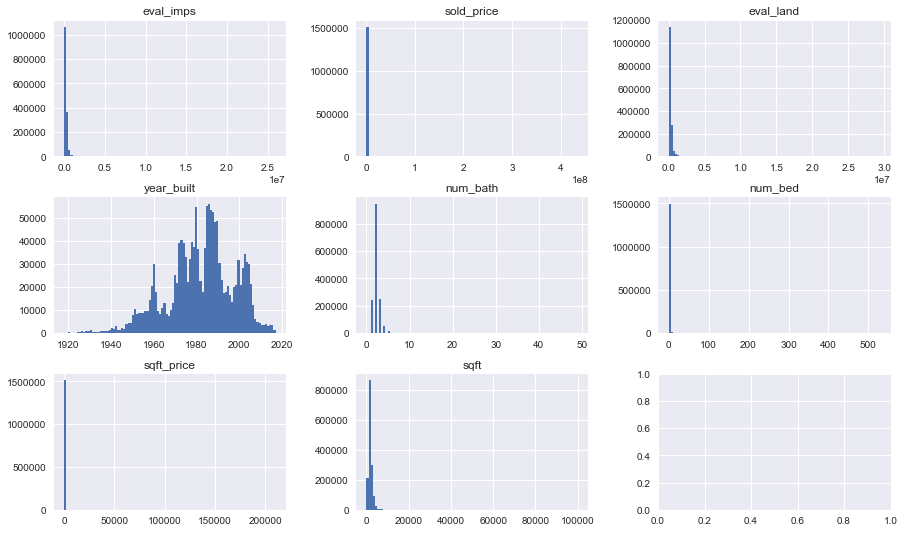

In [4]:
# check various feature distribution
columns = set(df_all.columns) - set(['pin'])
plot_feature_histogram(df_all, list(columns))

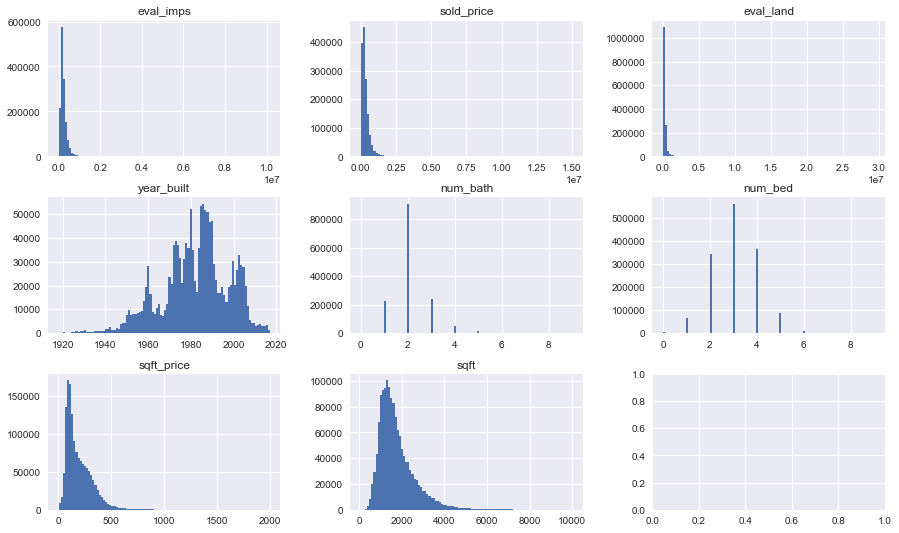

In [9]:
df_all_valid = df_all[(df_all['sqft_price']<2000) &(df_all['sqft_price']>0)
                     &(df_all['sqft']<10000)
                     &(df_all['sold_price']>0) 
                     #&(df_all['sold_price'] < 2000000)
                     &(df_all['num_bed']<10)
                     &(df_all['num_bath']<10)
                     ]
plot_feature_histogram(df_all_valid, list(columns))

In [10]:
df_all_valid[df_all_valid['sold_price']>2000000].shape

(8280, 18)

In [105]:
# check valid data size for each valid condition
pp = Preprocess(df_all)
valid_counts = pp.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

{'num_bath': 1512009,
 'num_bed': 1511762,
 'sold_price': 1449003,
 'sqft': 1511550,
 'sqft_price': 1448693,
 'total': 1512560}

In [109]:
# check the preprocess module set correct condition for valid range
df_all_valid1 = pp.dataset(feature='delivered', valid=True)
print(df_all_valid.shape[0])
print(df_all_valid1.shape[0])

converting view
converting pool
1446992
1446992


In [4]:
# last year transactions 
df_last_year = df_all[(pd.to_datetime(df_all['date']) >= '2016-10-01') & (pd.to_datetime(df_all['date']) < '2017-10-01')]
df_last_year.shape

(41100, 16)

In [6]:
df_last_year[df_last_year['sold_price']==0].shape

(3162, 16)

In [7]:
df_last_year[df_last_year['sold_price']==0][:10]

,pin,year_built,sqft,num_bed,num_bath,pool,view,str_no,street,st_type,unit_no,city,zip,sold_price,date,sqft_price
8,5561805536,1996.0,378,1.0,1.0,None,N,312,J,AVE,64,NATIONAL CITY,91950,0,2017-09-27,0
15,1876510400,1994.0,2462,5.0,3.0,N,Y,2349,SUMMIT CIRCLE,GLN,None,ESCONDIDO,92026,0,2017-09-27,0
56,4993631100,1959.0,1770,3.0,2.0,N,Y,3524,KENWOOD,DR,None,SPRING VALLEY,91977,0,2017-09-27,0
110,1613431500,1979.0,873,2.0,1.0,N,None,1444,HIGHRIDGE,DR,None,OCEANSIDE,92056,0,2017-09-26,0
224,3194015300,1987.0,1937,3.0,2.0,N,Y,11752,MIRA LAGO,WAY,None,SAN DIEGO,92131,0,2017-09-25,0
225,6720202700,1956.0,1242,4.0,2.0,N,N,5214,IRWIN,AVE,None,SAN DIEGO,92120,0,2017-09-25,0
233,5913312600,1985.0,1865,4.0,2.0,N,N,3020,PARKSIDE,PL,None,SAN DIEGO,92139,0,2017-09-25,0
273,1668100400,1994.0,1824,3.0,2.0,None,N,1424,JANIS LYNN,LN,None,VISTA,92083,0,2017-09-25,0
285,1866124400,1992.0,4822,5.0,4.0,Y,Y,28039,HIGH VISTA,DR,None,ESCONDIDO,92026,0,2017-09-25,0
350,4893802913,1982.0,1232,2.0,2.0,None,N,1166,DECKER,ST,B,EL CAJON,92019,0,2017-09-25,0


{'num_bath': 41088, 'sqft': 41081, 'sold_price': 37938, 'num_bed': 41079, 'total': 41100, 'sqft_price': 37918}


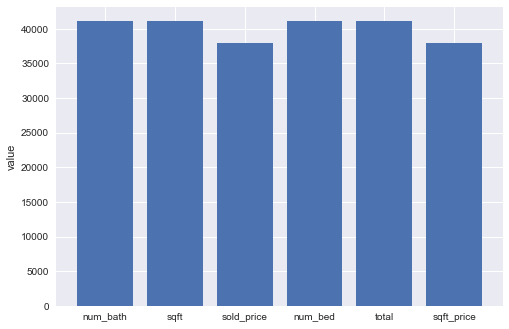

In [116]:
pp_last_year = Preprocess(df_last_year)
valid_counts = pp_last_year.get_valid_count()
print(valid_counts)
plot_bar(valid_counts)

In [117]:
df_last_year_valid = pp_last_year.dataset(feature='delivered', valid=True)
print(df_last_year_valid.shape[0])

converting view
converting pool
37881
